# Lab 11: Type-II Compensator Testing

#### Andrew Phillips

## Prelab: Design Type-II Compensator

For this prelab, I designed an analog Type-II compensator circuit to work with our UC2844 PWM controller. The requirements for the converter are highlighted below.

Requirements:
- Output voltage: 10V +/- 5%
- Zero steady-state error to a step change
- Closed-loop bandwidth equal to 1/8 switching frequency
- Closed-loop damping ratio of ζ=0.6

Based on these requirements, I knew I needed to shape my open loop transfer function to have a phase margin of 60 degrees to meet the damping ratio requirement, a cross over frequency of 6.25 kHz, and a high gain at DC (I picked 40dB to design for) to eliminate the DC error in the closed loop transfer function. To start shaping my loop, I first plotted my "plant" transfer function from the data I captured in Lab 9.

In [16]:
import csv
import pandas as pd

# read funky Rigol CSV format
def read_rigol_csv(csv_file_name):
    with open(csv_file_name) as f:
        rows = list(csv.reader(f))
        i = 0
        while rows[0][i] != "":
            i = i+1
        numcols = i-2
        t0 = float(rows[1][numcols])
        dT = float(rows[1][numcols+1])
    data = pd.read_csv(csv_file_name, usecols=range(0,numcols), skiprows=[1])
    data['X'] = t0+data['X']*dT
    return data, t0, dT

Text(0.5, 0, 'Frequency (Hz)')

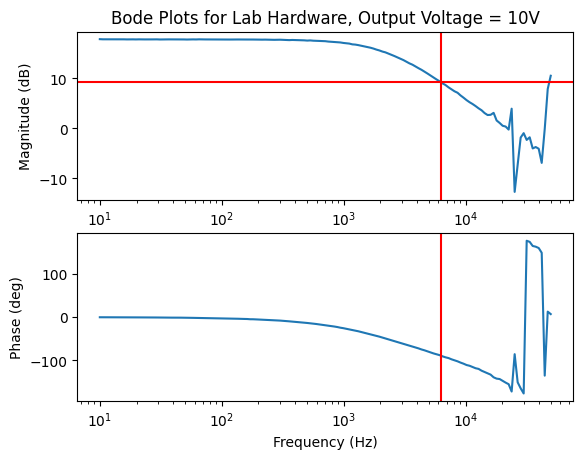

In [17]:
# bode plot from lab 9
import matplotlib.pyplot as plt

# import data
output_10V = pd.read_csv('data/lab_9_10V_output.csv')

# plot bode plots
figure, ax = plt.subplots(2,1)
# plot magnitudes
ax[0].plot(output_10V['Frequency (Hz)'],output_10V['Channel 2 Magnitude (dB)'])
ax[0].set_xscale('log')
ax[0].axvline(x=6250,color='r')
ax[0].axhline(y=9.3,color='r')
# plot phase shifts
ax[1].plot(output_10V['Frequency (Hz)'],output_10V['Channel 2 Phase (deg)'])
ax[1].set_xscale('log')
ax[1].axvline(x=6250,color='r')
# set labels
ax[0].set_title("Bode Plots for Lab Hardware, Output Voltage = 10V")
ax[0].set_ylabel("Magnitude (dB)")
ax[1].set_ylabel("Phase (deg)")
ax[1].set_xlabel("Frequency (Hz)")

From this data, I determined that the plant had a gain magnitude of 9.24 dB at the desired cutoff frequency, and a phase shift of -88.9 degrees. I put these parameters alongside the desired values into the code block below to determine the k-factor and cross over gain of the compensator circuit to achieve the desired requirements.

In [18]:
from math import tan, radians, sqrt
# calculation block
# desired parameters
fs = 50e3 # Hz
fco = fs*1/8 # crossover frequency, Hz
print(fco)
pm = 60 # desired phase margin, degrees (corresponds to damping ratio)
DC_gain_des = 40 # desired DC gain for open loop TF, in dB
Vo = 10 # desired output voltage

# plant parameters (from lab 9)
mag_fco_plant = 9.24 # plant magnitude at desired cutoff frequency
ps_fco_plant = -88.9 # plant phase shift at desired cutoff frequency
pm_plant = ps_fco_plant+180

# what we want
Kp = -mag_fco_plant # Kp value to achieve desired cutoff frequency
phase_boost = pm-(pm_plant-90) # required phase boost minus integrator
print("phase boost:",phase_boost)
# calculate k value
k = tan(radians(phase_boost)/2+radians(45))
print("k:",k)

# calculate TF parameters
fco_rad = fco*6.28 # convert to rad/s
Kp_linear = 0.34514373933585624 # convert to linear value

Gco = Kp_linear*fco_rad*sqrt((1+k**(-2))/(1+k**2))
print("Gco:",Gco)

6250.0
phase boost: 58.900000000000006
k: 3.593702440602003
Gco: 3769.619770373374


From these calculated parameters, I could then calculate components values for the 2 capacitors and 3 resistors in the Type-II compensator circuit.

In [19]:
# calculate component values
#step 1
Rf1 = 4.3e3 # typical sizing value
print("Selected Rf1:",Rf1)
#step 2
Cc1_calc = 1/(Gco*Rf1)
print("Calculated Cc1:",Cc1_calc)
Cc1 = 68e-9 # 68nF.
#step 3
Cc2_calc = Cc1/k**2
print("Calculated Cc2:",Cc2_calc)
Cc2 = 4.7e-9 # 4.7 nF
#step 4
Rc1_calc = 1/(fco_rad*sqrt(Cc1*Cc2))
print("Calculated Rc1:",Rc1_calc)
Rc1 = 1.5e3 # 1.5 kOhms
#step 5
Rf2_calc = Rf1*2.5/(Vo-2.5)
print("Calculated Rf2:",Rf2_calc)
Rf2 = 1.5e3 # 1.5 kOhms

Selected Rf1: 4300.0
Calculated Cc1: 6.169273128357167e-08
Calculated Cc2: 5.2653189448123445e-09
Calculated Rc1: 1425.1381092662991
Calculated Rf2: 1433.3333333333333


To verify these component selections, I simulated my designed compensator circuit in PLECS. The model has been included in the submission, and a screenshot of the model and scope traces have been included below (top trace is shunt voltage, middle trace is drain voltage, and bottom trace is output voltage). Based on the plotted waveforms, it appears that the circuit is working as intended, maintaining the desired output voltage.

![plecs_prelab](images/plecs_prelab.png)

![scope_prelab](images/scope_prelab.png)

## Data Collection

In this lab, we used the AD2 to inject signals into our lab hardware to analyze the open and closed loop transfer functions of our circuit with our designed compensator components implemented in our circuit. We then measured the step response of our circuit to an injected square wave. The data from our open loop, closed loop, and step response measurements are plotted below:

### Baseline Measurements

Text(0.5, 1.0, 'Baseline Shunt Voltage at 10V Output')

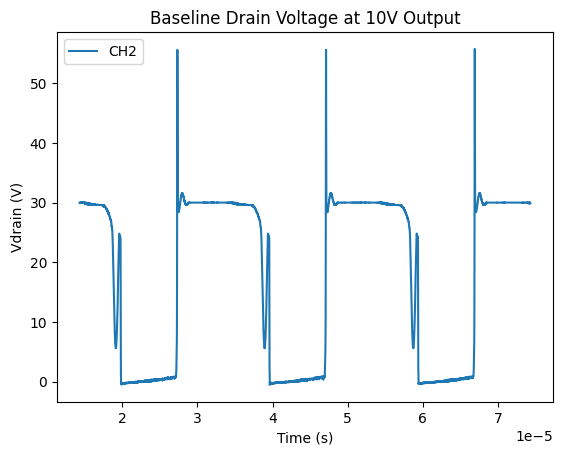

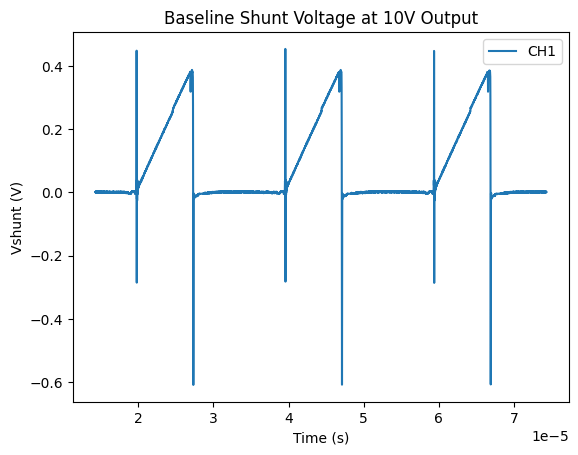

In [20]:
# plot baseline measurements
[baseline_data, baseline_data_t0, baseline_data_dT] = read_rigol_csv('data/lab_11_baseline.csv')

# apply data filter
baseline_data['CH1'] = baseline_data['CH1'].rolling(10).mean()
baseline_data['CH2'] = baseline_data['CH2'].rolling(10).mean()

# plot drain voltage
fig, ax = plt.subplots()
baseline_data.plot(x="X", y="CH2", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Baseline Drain Voltage at 10V Output")

# plot shunt voltage
fig, ax = plt.subplots()
baseline_data.plot(x="X", y="CH1", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vshunt (V)")
ax.set_title("Baseline Shunt Voltage at 10V Output")

## Post-Lab Analysis

#### Open-Loop Transfer Function Measurements

Text(0.5, 0, 'Frequency (Hz)')

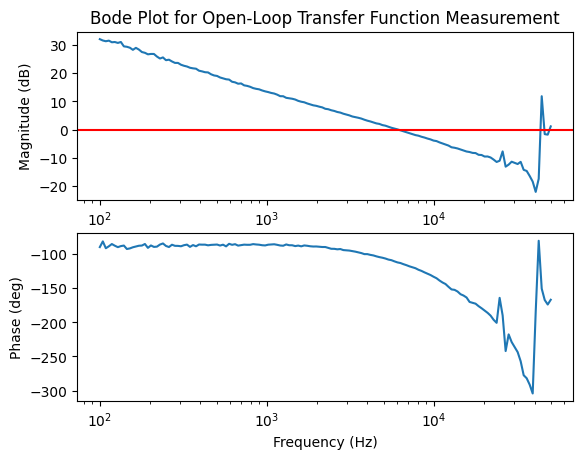

In [21]:
# import data
open_loop = pd.read_csv('data/open_loop.csv', header=19)

# plot bode plot
figure, ax = plt.subplots(2,1)

# plot magnitude
ax[0].plot(open_loop['Frequency (Hz)'],open_loop['Channel 2 Magnitude (dB)'])
ax[0].set_xscale('log')
ax[0].axhline(y=0,color='r')

# plot phase shift
ax[1].plot(open_loop['Frequency (Hz)'],open_loop['Channel 2 Phase (deg)'])
ax[1].set_xscale('log')

# set labels
ax[0].set_title("Bode Plot for Open-Loop Transfer Function Measurement")
ax[0].set_ylabel("Magnitude (dB)")
ax[1].set_ylabel("Phase (deg)")
ax[1].set_xlabel("Frequency (Hz)")
# phase margin should be around 68 degrees

2. Given the bode plot above, the open-loop transfer function has a cross-over frequency of 6.3kHz, a phase margin of 67.7 degrees, and a gain margin of 9.56dB.

3. Based on the above parameters, the requirements of the converter are being met. The phase margin is above the desired 60 degrees (as dictated by the desired damping ratio), the cross-over frequency is close to our desired cross-over frequency of 6.25 kHz, and we see a high gain at DC (indicated by the transfer function having a pole at 0), showing that the closed-loop transfer function should have unity gain at DC. In addition, we see the gain continue to roll off at higher frequencies, which should reduce the response delay of the system.

#### Closed-Loop Transfer Function Measurements

Text(0.5, 0, 'Frequency (Hz)')

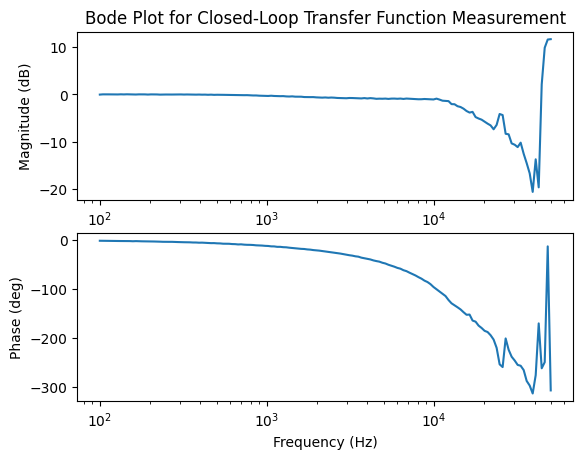

In [22]:
# import data
closed_loop = pd.read_csv('data/closed_loop.csv', header=19)
# plot bode plot
figure, ax = plt.subplots(2,1)

# plot magnitude
ax[0].plot(closed_loop['Frequency (Hz)'],closed_loop['Channel 2 Magnitude (dB)'])
ax[0].set_xscale('log')

# plot phase shift
ax[1].plot(closed_loop['Frequency (Hz)'],closed_loop['Channel 2 Phase (deg)'])
ax[1].set_xscale('log')

# set labels
ax[0].set_title("Bode Plot for Closed-Loop Transfer Function Measurement")
ax[0].set_ylabel("Magnitude (dB)")
ax[1].set_ylabel("Phase (deg)")
ax[1].set_xlabel("Frequency (Hz)")

5. The closed-loop transfer function has a cut-off frequency and bandwidth of 15 kHz (where the gain of the Bode plot reaches -3 dB).

6. It looks like some of the requirements of the transfer function are being fulfilled here. The transfer function has unity gain at DC, eliminating any DC offset from the transfer function. However, the bandwidth of the transfer function is larger than desired, at around 15 kHz. This may indicate that the step response of the system may be more sluggish than desired. In addition, the poles appear to be much more closely spaced in this closed loop transfer function compared to the previous lab.

#### Step-Response Measurements

Text(0.5, 0, 'Time (s)')

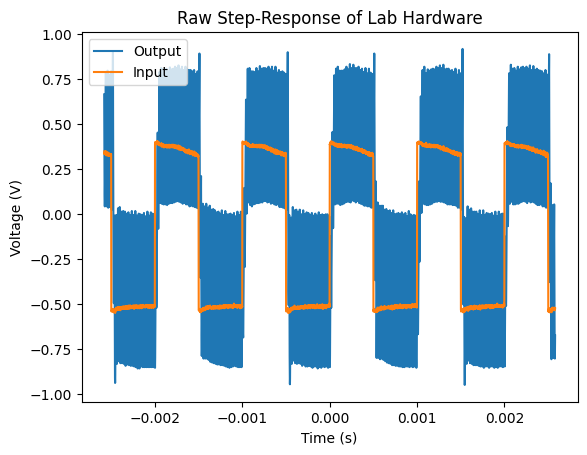

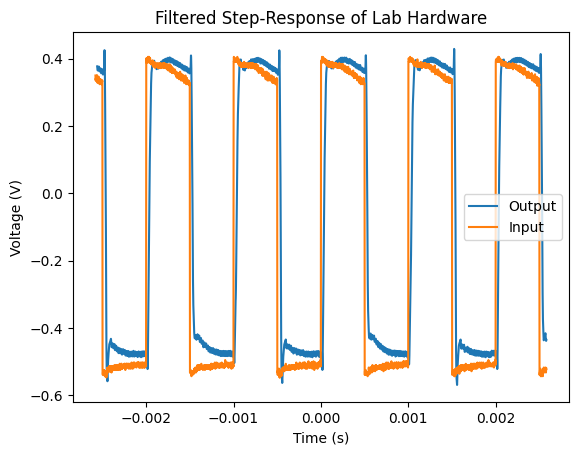

In [23]:
import numpy as np

# import data
step_res = pd.read_csv('data/step_response.csv', header=18)
# add channel 2 offset
step_res['Channel 2 (V)'] += 9.7

# save offset data in new CSV
# step_res.to_csv('data/step_response_offset.csv')

# plot raw data
figure, ax = plt.subplots()
ax.plot(step_res['Time (s)'],step_res['Channel 2 (V)'])
ax.plot(step_res['Time (s)'],step_res['Channel 1 (V)'])

# set labels
ax.set_title("Raw Step-Response of Lab Hardware")
ax.legend(["Output","Input"])
ax.set_ylabel("Voltage (V)")
ax.set_xlabel("Time (s)")

# filter data
diff = 0
for i in range(len(step_res["Time (s)"])-1):
    diff += step_res["Time (s)"][i+1]-step_res["Time (s)"][i]

diff/=len(step_res["Time (s)"])-1 
ts = 1/50e3
avg_num = int(np.round(ts/diff))
step_res["Channel 2 (V)"] = step_res['Channel 2 (V)'].rolling(avg_num).mean()

# save filtered data in new CSV
step_res.to_csv('data/step_response_filtered.csv')

# plot filtered data
figure, ax = plt.subplots()
ax.plot(step_res['Time (s)'],step_res['Channel 2 (V)'])
ax.plot(step_res['Time (s)'],step_res['Channel 1 (V)'])

# set labels
ax.set_title("Filtered Step-Response of Lab Hardware")
ax.legend(["Output","Input"])
ax.set_ylabel("Voltage (V)")
ax.set_xlabel("Time (s)")

8. The step response overshoot of our system is virtually 0, indicating that our system is overdamped. This results in a relatively sluggish response in comparison to an underdamped system, but also results in 0 overshoots present in the system.

9. There is no overshoot due to the overdamped nature of the system. The step response is also somewhat sluggish because of this. This is more pronounced on the falling edge step response, where our output only reaches a steady state value after half of the step time. The steady-state error is relatively low on the high and low states of the step response (4% on the low and 9% on the high).

10. I modelled the step response in PLECS, similarly using an isolation transformer and using a pulse generator to simulate the signal injection from the AD2. Screenshots from the model and scope trace (with the input signal being on the top and the output response being on the bottom) are shown below, and the model is included with the submission.

![plecs_stepres](images/plecs_step_response.png)

![scope_stepres](images/scope_step_response.png)

The PLECS model actually shows an underdamped response, with the output over and undershooting several times at each input change. Calculating the damping ratio with the equation below results in a damping ratio of 0.45, which although not exact is much closer to what the open-loop transfer function would suggest about the converter's damping ratio.

![damping](images/damp_eq_2.png)